In [1]:
pip install xgboost

   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
    --------------------------------------- 1.3/72.0 MB 10.0 MB/s eta 0:00:08
   -- ------------------------------------- 3.7/72.0 MB 10.3 MB/s eta 0:00:07
   -- ------------------------------------- 4.5/72.0 MB 8.3 MB/s eta 0:00:09
   --- ------------------------------------ 5.8/72.0 MB 7.7 MB/s eta 0:00:09
   --- ------------------------------------ 7.1/72.0 MB 7.3 MB/s eta 0:00:09
   ---- ----------------------------------- 7.3/72.0 MB 6.6 MB/s eta 0:00:10
   ---- ----------------------------------- 7.6/72.0 MB 6.1 MB/s eta 0:00:11
   ---- ----------------------------------- 7.9/72.0 MB 5.2 MB/s eta 0:00:13
   ---- ----------------------------------- 8.1/72.0 MB 4.7 MB/s eta 0:00:14
   ---- ----------------------------------- 8.4/72.0 MB 4.3 MB/s eta 0:00:15
   ---- ----------------------------------- 8.7/72.0 MB 4.1 MB/s eta 0:00:16
   ----- ---------------------------------- 9.2/72.0 MB 3.8 MB/s eta 0:00:17
   -


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# ============================================================
# Telecom Churn Data Cleaning + Model Training Pipeline
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

# ============================================================
# 1️⃣ Load and Basic Cleaning
# ============================================================

df = pd.read_csv(r"E:\Code Space\churn_prediction_mlops\data\raw\data2.csv")

# Create churn label (churn = 1 if ARPU_9 == 0)
df['churn'] = df['arpu_9'].apply(lambda x: 1 if x == 0 else 0)

# Drop non-predictive or identifier columns
drop_cols = [c for c in df.columns if 'date' in c or 'mobile_number' in c]
df.drop(columns=drop_cols, inplace=True)

# Drop columns with >70% missing
threshold = 0.7 * df.shape[0]
df = df.dropna(thresh=threshold, axis=1)

# Fill remaining missing with 0
df.fillna(0, inplace=True)

print(f"✅ After basic cleaning: {df.shape[1]} columns, {df.shape[0]} rows")

# ============================================================
# 2️⃣ Outlier Capping using IQR
# ============================================================

def cap_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df[col] = np.where(df[col] < lower, lower,
                       np.where(df[col] > upper, upper, df[col]))
    return df

numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
numeric_cols.remove("churn")

for col in numeric_cols:
    df = cap_outliers(df, col)

print("✅ Outliers capped.")

# ============================================================
# 3️⃣ Log Transform for Skewed Features
# ============================================================

# Apply log1p to only positive numeric columns
for col in numeric_cols:
    if (df[col] > 0).any():
        df[col] = np.log1p(df[col])

# Replace infs or NaNs
df = df.replace([np.inf, -np.inf], np.nan)
df.fillna(0, inplace=True)

print("✅ Log transform + NaN handling complete.")

# ============================================================
# 4️⃣ Optional Scaling (For XGBoost/SVM etc.)
# ============================================================

scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

print("✅ Scaling complete.")

# ============================================================
# 5️⃣ Save Processed Data
# ============================================================

processed_path = r"E:\Code Space\churn_prediction_mlops\data\processed\telecom_churn_cleaned1.csv"
df.to_csv(processed_path, index=False)
print(f"📁 Saved cleaned dataset to: {processed_path}")

# ============================================================
# 6️⃣ Train-Test Split
# ============================================================

X = df.drop(columns=["churn"])
y = df["churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

# ============================================================
# 7️⃣ Model Training & Evaluation
# ============================================================

def evaluate_model(model, X_train, X_test, y_train, y_test, name):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    probas = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else preds

    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    auc = roc_auc_score(y_test, probas)

    print(f"\n📊 {name} Results:")
    print(f"Accuracy: {acc:.4f} | F1: {f1:.4f} | ROC-AUC: {auc:.4f}")
    print(classification_report(y_test, preds))
    return acc, f1, auc

# ------------------------------------------------------------
# LightGBM
lgbm = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=7,
    random_state=42,
    n_jobs=-1
)
evaluate_model(lgbm, X_train, X_test, y_train, y_test, "LightGBM")

# ------------------------------------------------------------
# CatBoost
cat = CatBoostClassifier(
    iterations=300,
    learning_rate=0.05,
    depth=8,
    eval_metric='AUC',
    random_seed=42,
    verbose=False
)
evaluate_model(cat, X_train, X_test, y_train, y_test, "CatBoost")

# ------------------------------------------------------------
# XGBoost
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
evaluate_model(xgb, X_train, X_test, y_train, y_test, "XGBoost")

print("\n✅ All models trained and evaluated successfully.")


✅ After basic cleaning: 178 columns, 99999 rows
✅ Outliers capped.


e:\Code Space\churn_prediction_mlops\venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
e:\Code Space\churn_prediction_mlops\venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


✅ Log transform + NaN handling complete.
✅ Scaling complete.
📁 Saved cleaned dataset to: E:\Code Space\churn_prediction_mlops\data\processed\telecom_churn_cleaned1.csv
Train shape: (79999, 177), Test shape: (20000, 177)
[LightGBM] [Info] Number of positive: 7255, number of negative: 72744
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026792 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22606
[LightGBM] [Info] Number of data points in the train set: 79999, number of used features: 98
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090689 -> initscore=-2.305256
[LightGBM] [Info] Start training from score -2.305256
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

e:\Code Space\churn_prediction_mlops\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [00:11:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📊 XGBoost Results:
Accuracy: 0.9947 | F1: 0.9712 | ROC-AUC: 0.9987
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     18186
           1       0.95      1.00      0.97      1814

    accuracy                           0.99     20000
   macro avg       0.97      0.99      0.98     20000
weighted avg       0.99      0.99      0.99     20000


✅ All models trained and evaluated successfully.


<Figure size 1000x600 with 0 Axes>

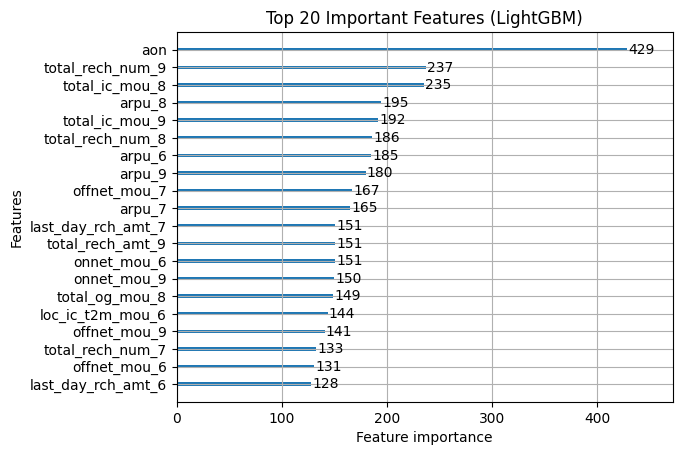

In [3]:
import matplotlib.pyplot as plt
from lightgbm import plot_importance

plt.figure(figsize=(10,6))
plot_importance(lgbm, max_num_features=20)
plt.title("Top 20 Important Features (LightGBM)")
plt.show()


In [4]:
import joblib
joblib.dump(cat, "best_catboost_model.pkl")


['best_catboost_model.pkl']

In [5]:
import joblib
import os

model_dir = r"E:\Code Space\churn_prediction_mlops\models"
os.makedirs(model_dir, exist_ok=True)

# Save each model
joblib.dump(lgbm, os.path.join(model_dir, "lightgbm_model.pkl"))
joblib.dump(cat, os.path.join(model_dir, "catboost_model.pkl"))
joblib.dump(xgb, os.path.join(model_dir, "xgboost_model.pkl"))

print(f"\n💾 Models saved successfully in: {model_dir}")


💾 Models saved successfully in: E:\Code Space\churn_prediction_mlops\models
